In [183]:
# From:
# https://gist.github.com/eljost/2c4e1af652ef02b2989da341c5569af7
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
import scipy.stats as st

## Generic Gaussian process example

In [3]:
np.random.seed(1)

# Quadratic 2d potential
def func(x):
    return np.sum(x**2, axis=-1)


# Grid
lim = 1
res = 50
lin = np.linspace(-lim, lim, res)

# x1.shape = (50, 50)
x1, x2 = np.meshgrid(lin, lin)
# xx.shape = (2500, 2)
xx = np.vstack((x1.flatten(), x2.flatten())).T

# Analytic function values
y_analytic = func(xx)
y_analytic = y_analytic.reshape(-1, res)

# Observed data
obs = 15
# X.shape = (15, 2)
X = np.stack(
        (np.random.choice(lin, obs), np.random.choice(lin, obs)),
        axis=-1
)
y_obs = func(X)

kernel = RBF()
gp = GaussianProcessRegressor(kernel=kernel,
                              n_restarts_optimizer=10)
gp.fit(X, y_obs)
print("Learned kernel", gp.kernel_)
# y_mean.shape = (2500, )
# y_cov.shape = (2500, 2500)
y_mean, y_cov = gp.predict(xx, return_cov=True)

posterior_nums = 3
posteriors = st.multivariate_normal.rvs(mean=y_mean, cov=y_cov,
                                        size=posterior_nums)

Learned kernel RBF(length_scale=0.86)


In [42]:
xx.shape

(2500, 2)

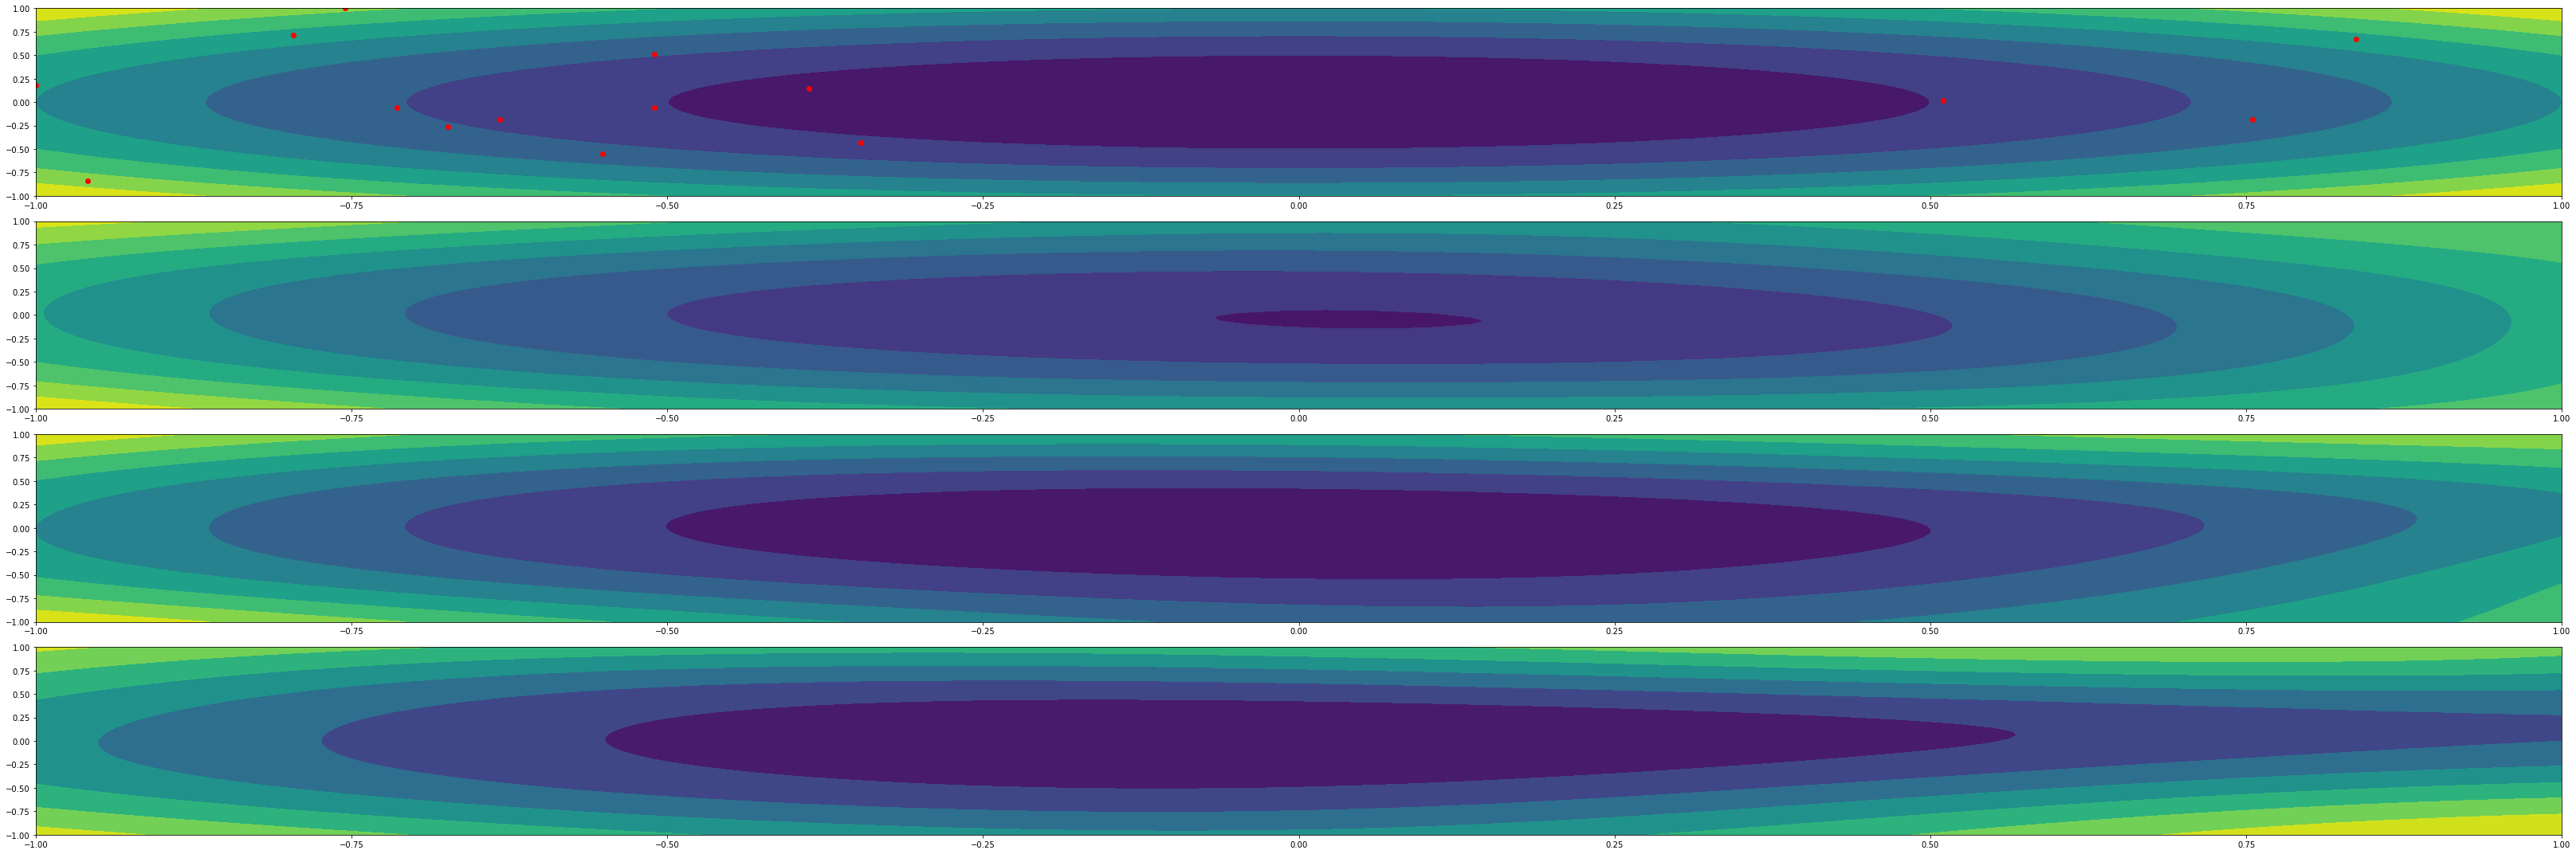

In [2]:

fig, axs = plt.subplots(posterior_nums+1, figsize=(45,15))

ax = axs[0]
ax.contourf(x1, x2, y_analytic)
ax.plot(X[:, 0], X[:, 1], "r.", ms=12)

for i, post in enumerate(posteriors, 1):
    axs[i].contourf(x1, x2, post.reshape(-1, res))

plt.tight_layout()
plt.show()

## Now, with feature-matching vectors

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_affine import *

In [9]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)

### Get the feature matches

In [203]:
opt = {'start_frame':0,
       'num_frames':3,
      'num_reference_frames':2,
      'start_slice':4}
all_matches, all_other_frames, reference_set = track_via_reference_frames(btf_fname_red, **opt)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.91s/it]


### Build a vector field from this

In [83]:
pts0_unmatched = reference_set.reference_frames[0].keypoint_locs
pts1_unmatched = reference_set.reference_frames[1].keypoint_locs
feature_matches = reference_set.feature_matches[(0,1)]

n0_unmatched = reference_set.reference_frames[0].neuron_locs
n1_unmatched = reference_set.reference_frames[1].neuron_locs
all_matches = reference_set.pairwise_matches[(0,1)]

In [89]:
# Align the keypoints via matches
xyz = np.zeros((len(all_matches), 3), dtype=np.float32) # Start point
dat = np.zeros((len(all_matches), 3), dtype=np.float32) # Difference vector
f_xyz = np.zeros((len(feature_matches), 3), dtype=np.float32) # Start point
f_dat = np.zeros((len(feature_matches), 3), dtype=np.float32) # Difference vector

for m, f_match in enumerate(feature_matches):
    v0 = pts0_unmatched[f_match.queryIdx]
    v1 = pts1_unmatched[f_match.trainIdx]
    f_xyz[m, :] = v0
    f_dat[m, :] = v1 - v0
    
for m, match in enumerate(all_matches):
    v0 = n0_unmatched[match[0]]
    v1 = n1_unmatched[match[1]]
    xyz[m, :] = v0
    dat[m, :] = v1 - v0

<IPython.core.display.Javascript object>


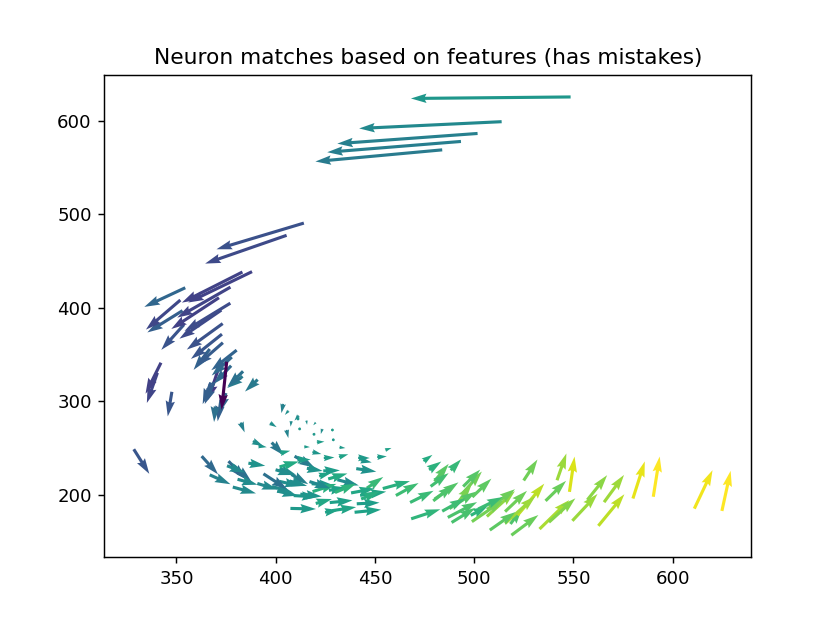

Text(0.5, 1.0, 'Neuron matches based on features (has mistakes)')

In [91]:
%matplotlib notebook

C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], dat[:,1], dat[:,2], C)
plt.title('Neuron matches based on features (has mistakes)')

### Finally, GP

In [156]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(xyz)
xyz_scaled = scaler.transform(xyz)

In [176]:
# Do each coordinate independently

kernel = RBF(length_scale=2, length_scale_bounds=(1e-08, 10.0)) + \
    WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-4, 1))
opt = {'n_restarts_optimizer':10, 'alpha':0.0}
gpx = GaussianProcessRegressor(kernel=kernel,**opt)
gpx.fit(xyz_scaled[:,1:], dat[:,1])
gpy = GaussianProcessRegressor(kernel=kernel,**opt)
gpy.fit(xyz_scaled[:,1:], dat[:,2])
gpz = GaussianProcessRegressor(kernel=kernel,**opt)
gpz.fit(xyz_scaled[:,1:], dat[:,0])
print("Learned x kernel", gpx.kernel_)
print("Learned y kernel", gpy.kernel_)

x_predict, x_cov = gpx.predict(xyz_scaled[:,1:], return_cov=True)
y_predict, y_cov = gpy.predict(xyz_scaled[:,1:], return_cov=True)
z_predict, z_cov = gpz.predict(xyz_scaled[:,1:], return_cov=True)

# posterior_nums = 3
# posteriors = st.multivariate_normal.rvs(mean=y_mean, cov=y_cov,
#                                         size=posterior_nums)

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Learned x kernel RBF(length_scale=2.08) + WhiteKernel(noise_level=1)
Learned y kernel RBF(length_scale=1.4) + WhiteKernel(noise_level=1)


<IPython.core.display.Javascript object>


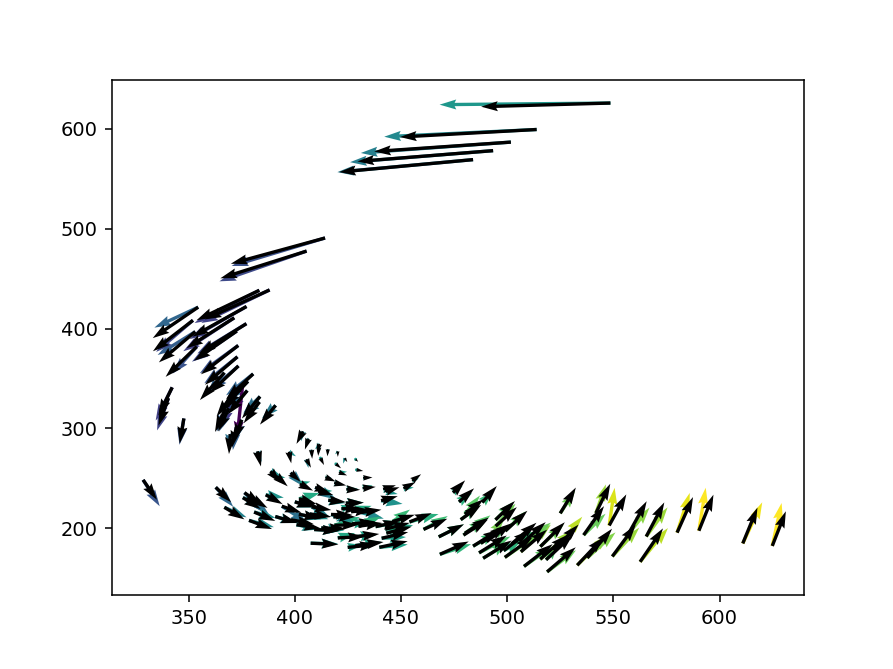

In [177]:
%matplotlib notebook

C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], dat[:,1], dat[:,2], C)

# C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], x_predict, y_predict)

In [165]:
import open3d as o3d


In [179]:
# Original
pc0 = o3d.geometry.PointCloud()
pc0.points = o3d.utility.Vector3dVector(xyz)
pc0.paint_uniform_color([0,0,0])

# Where the points originally matched
pc1 = o3d.geometry.PointCloud()
pc1.points = o3d.utility.Vector3dVector(xyz + dat)
pc1.paint_uniform_color([0.5,0.5,0.5])

# line with the GP prediction
pc_gp = o3d.geometry.PointCloud()
dat_predict = np.transpose(np.vstack([z_predict, x_predict, y_predict]))
pc_gp.points = o3d.utility.Vector3dVector(xyz + dat_predict)
gp_lines = build_line_set_from_matches(pc0, pc_gp,
                                color=[0, 0, 1])


# o3d.visualization.draw_geometries([pc0, pc1, gp_lines])

In [181]:
f0, f1 = reference_set.reference_frames
to_draw = visualize_tracks(f0.neuron_locs, f1.neuron_locs, all_matches)
to_draw.append(gp_lines)

o3d.visualization.draw_geometries(to_draw)

### Try 2: train on feature matches, and predict on neurons

In [117]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(f_xyz)
f_xyz_scaled = scaler.transform(f_xyz)
xyz_scaled = scaler.transform(xyz)

ind = np.random.choice(f_xyz.shape[0], 500, replace=False)

In [154]:
# Do each coordinate independently

kernel = RBF(length_scale=0.5, length_scale_bounds=(1e-08, 10.0)) + \
    WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-4, 1))
opt = {'n_restarts_optimizer':10, 'alpha':1e-10}
gpx = GaussianProcessRegressor(kernel=kernel,**opt)
gpx.fit(f_xyz_scaled[ind,1:], f_dat[ind,1])
gpy = GaussianProcessRegressor(kernel=kernel,**opt)
gpy.fit(f_xyz_scaled[ind,1:], f_dat[ind,2])
print("Learned x kernel", gpx.kernel_)
print("Learned y kernel", gpy.kernel_)

x_predict, x_cov = gpx.predict(xyz_scaled[:,1:], return_cov=True)
y_predict, y_cov = gpy.predict(xyz_scaled[:,1:], return_cov=True)

# posterior_nums = 3
# posteriors = st.multivariate_normal.rvs(mean=y_mean, cov=y_cov,
#                                         size=posterior_nums)

C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Learned x kernel RBF(length_scale=1.76) + WhiteKernel(noise_level=1)
Learned y kernel RBF(length_scale=0.682) + WhiteKernel(noise_level=1)


<IPython.core.display.Javascript object>


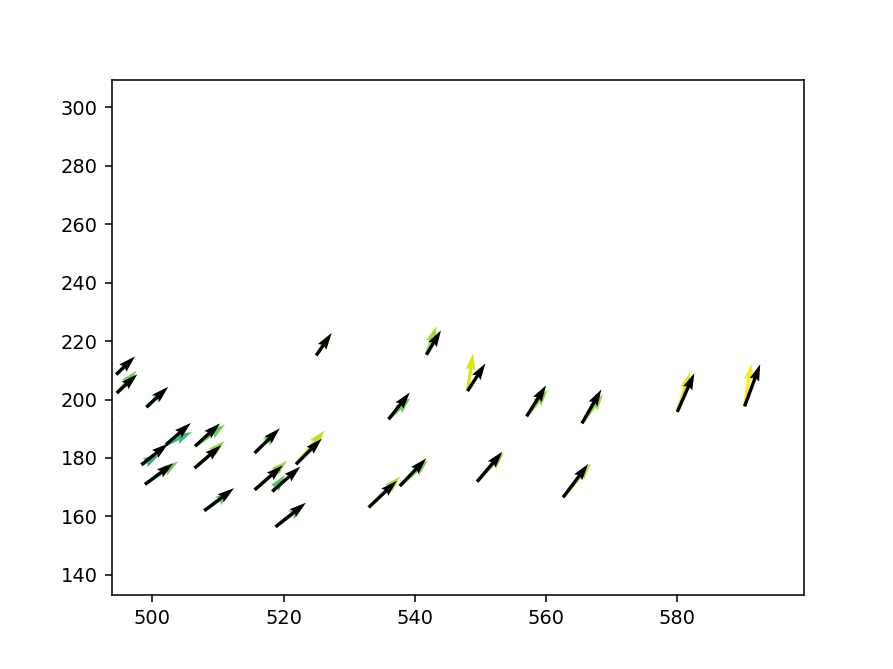

In [155]:
%matplotlib notebook

C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], dat[:,1], dat[:,2], C)

# C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], x_predict, y_predict)

## Using non-isotropic basis function

In [226]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(xyz)
# f_xyz_scaled = scaler.transform(f_xyz)
xyz_scaled = scaler.transform(xyz)

# ind = np.random.choice(f_xyz.shape[0], 500, replace=False)

In [193]:
# Do each coordinate independently

kernel = DotProduct(sigma_0=1.0) + \
    RBF(length_scale=0.5, length_scale_bounds=(1e-08, 10.0)) + \
    WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-4, 1))

opt = {'n_restarts_optimizer':10, 'alpha':0.0}
gpx = GaussianProcessRegressor(kernel=kernel,**opt)
gpx.fit(xyz_scaled[:,1:], dat[:,1])
gpy = GaussianProcessRegressor(kernel=kernel,**opt)
gpy.fit(xyz_scaled[:,1:], dat[:,2])
gpz = GaussianProcessRegressor(kernel=kernel,**opt)
gpz.fit(xyz_scaled[:,1:], dat[:,0])
print("Learned x kernel", gpx.kernel_)
print("Learned y kernel", gpy.kernel_)

x_predict, x_cov = gpx.predict(xyz_scaled[:,1:], return_cov=True)
y_predict, y_cov = gpy.predict(xyz_scaled[:,1:], return_cov=True)
z_predict, z_cov = gpz.predict(xyz_scaled[:,1:], return_cov=True)


C:\Users\charles.fieseler\Anaconda3\envs\track_using_features\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Learned x kernel DotProduct(sigma_0=16.1) + RBF(length_scale=0.00104) + WhiteKernel(noise_level=1)
Learned y kernel DotProduct(sigma_0=5.68) + RBF(length_scale=6.85e-07) + WhiteKernel(noise_level=1)


<IPython.core.display.Javascript object>


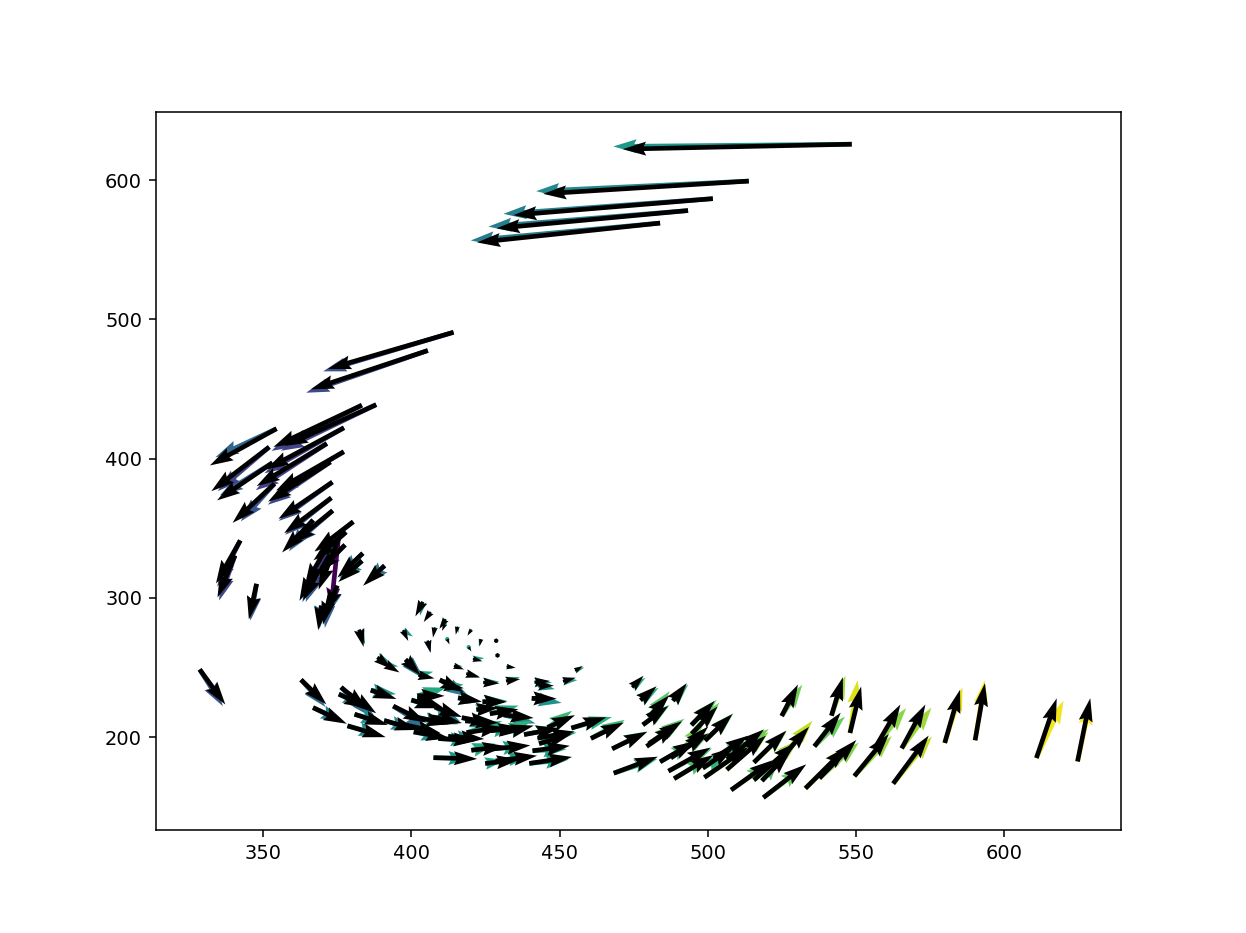

In [194]:
%matplotlib notebook

C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], dat[:,1], dat[:,2], C)

# C = dat[:,2] / np.max(dat[:,1])
plt.quiver(xyz[:,1], xyz[:,2], x_predict, y_predict)

In [259]:
## POINT CLOUD TIME

# n0_unmatched = reference_set.reference_frames[0].neuron_locs
# n1_unmatched = reference_set.reference_frames[1].neuron_locs
all_matches = reference_set.pairwise_matches[(0,1)]
all_conf = reference_set.pairwise_conf[(0,1)]
all_m, all_c, to_remove_ind = keep_best_match(all_matches, all_conf)

# Only keep the best points
xyz2 = np.zeros((len(all_m), 3), dtype=np.float32) # Start point
dat2 = np.zeros((len(all_m), 3), dtype=np.float32) # Difference vector
for m, match in enumerate(all_m):
    v0 = n0_unmatched[match[0]]
    v1 = n1_unmatched[match[1]]
    xyz2[m, :] = v0
    dat2[m, :] = v1 - v0

# Use scaled versions of points
pc0 = build_neuron_tree(xyz2, False)[1]
pc0.paint_uniform_color([0,0,0])
pc1 = build_neuron_tree(xyz2+dat2, False)[1]
pc1.paint_uniform_color([0.5,0.5,0.5])

original_lines = build_line_set_from_matches(pc0, pc1, matches=None)

# Point cloud and lines for the pushed neurons
xyz_pushed = np.transpose(np.vstack([z_predict, x_predict, y_predict]))
# xyz_pushed = scaler.inverse_transform(xyz_pushed)
pc_pushed = build_neuron_tree(xyz+xyz_pushed, False)[1]

pc0_tmp = build_neuron_tree(xyz, False)[1]
new_lines = build_line_set_from_matches(pc0_tmp, pc_pushed, matches=None, color=[1,0,0])


In [260]:
import open3d as o3d

o3d.visualization.draw_geometries([pc0, pc1, original_lines, new_lines])

In [253]:
all_m

[[4, 111],
 [12, 82],
 [13, 34],
 [19, 22],
 [36, 43],
 [40, 23],
 [41, 142],
 [44, 15],
 [45, 16],
 [46, 27],
 [53, 20],
 [55, 19],
 [58, 24],
 [61, 17],
 [62, 14],
 [63, 26],
 [64, 13],
 [65, 10],
 [66, 28],
 [67, 11],
 [68, 33],
 [70, 25],
 [72, 49],
 [73, 51],
 [75, 98],
 [76, 42],
 [77, 48],
 [78, 54],
 [79, 56],
 [80, 46],
 [81, 41],
 [82, 83],
 [83, 69],
 [84, 60],
 [85, 38],
 [86, 78],
 [87, 64],
 [88, 77],
 [89, 62],
 [90, 108],
 [93, 63],
 [94, 112],
 [97, 130],
 [98, 70],
 [99, 50],
 [100, 87],
 [102, 52],
 [103, 40],
 [104, 35],
 [107, 66],
 [108, 45],
 [110, 68],
 [111, 67],
 [112, 37],
 [113, 31],
 [114, 73],
 [115, 88],
 [116, 90],
 [117, 55],
 [118, 81],
 [119, 86],
 [120, 58],
 [123, 53],
 [124, 57],
 [125, 79],
 [126, 92],
 [127, 95],
 [135, 12],
 [137, 84],
 [138, 89],
 [139, 103],
 [141, 99],
 [142, 75],
 [143, 91],
 [145, 107],
 [147, 72],
 [148, 110],
 [150, 102],
 [151, 105],
 [152, 96],
 [153, 104],
 [154, 140],
 [156, 113],
 [157, 85],
 [158, 100],
 [160, 114],